# ML Reasoning Extraction & Structural Comparison

## Research Goal
To extract high-granularity dependency DAGs (12–18 variables) from multiple ML models and compare them with the previously derived generalized (human) DAG. We treat each model as a distinct reasoning system and expose its internal structure.

--- 
## 🔹 Unit 1 — Foundations & Master Data
We load the master dataset derived in the Behavioral Causal Atlas to ensure a consistent node set for all comparison models.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
D = '/Users/srimanarayana/Thesis Master/Data/INS-W_1/FeatureData'

**🧠 Interpretation**
**Observation**: Essential ML and Graph libraries are initialized.
**Implication**: The environment is ready for multi-model reasoning extraction.
**Decision**: Load the cleaned 14-variable master dataset.

In [2]:
def load_g(f, cols): return pd.read_csv(f'{D}/{f}.csv')[['pid', 'date'] + list(cols.values())].rename(columns={v:k for k,v in cols.items()})
slp = load_g('sleep', {'Sleep_Dur': 'f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist', 'Sleep_Eff': 'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:14dhist', 'Sleep_Lat': 'f_slp:fitbit_sleep_summary_rapids_avgdurationtofallasleepmain:14dhist'})
stp = load_g('steps', {'Step_Vol': 'f_steps:fitbit_steps_summary_rapids_avgsumsteps:14dhist', 'Active_Bout': 'f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout:14dhist'})
loc = load_g('location', {'Home_Time': 'f_loc:phone_locations_barnett_hometime:14dhist', 'Dist_Trav': 'f_loc:phone_locations_barnett_disttravelled:14dhist', 'Loc_Ent': 'f_loc:phone_locations_doryab_locationentropy_norm:14dhist'})
dig = pd.read_csv(f'{D}/call.csv').merge(pd.read_csv(f'{D}/screen.csv'), on=['pid','date'])[['pid','date','f_screen:phone_screen_rapids_countepisodeunlock:14dhist', 'f_screen:phone_screen_rapids_sumdurationunlock:14dhist', 'f_call:phone_calls_rapids_incoming_count:14dhist', 'f_call:phone_calls_rapids_outgoing_count:14dhist']]
dig.columns = ['pid','date','Unlock_Freq','Screen_Vol','Inc_Soc','Out_Soc']
out = pd.read_csv('/Users/srimanarayana/Thesis Master/Data/INS-W_1/SurveyData/dep_weekly.csv')[['pid','date','dep']]
df = slp.merge(stp, on=['pid','date']).merge(loc, on=['pid','date']).merge(dig, on=['pid','date']).merge(out, on=['pid','date']).dropna()
X = StandardScaler().fit_transform(df.drop(columns=['pid', 'date', 'dep']))
y = df['dep']

/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_13093/1017976730.py:5: DtypeWarning: Columns (0: f_call:phone_calls_rapids_missed_timefirstcall_dis:night, 1: f_call:phone_calls_rapids_missed_timelastcall_dis:night, 2: f_call:phone_calls_rapids_incoming_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  dig = pd.read_csv(f'{D}/call.csv').merge(pd.read_csv(f'{D}/screen.csv'), on=['pid','date'])[['pid','date','f_screen:phone_screen_rapids_countepisodeunlock:14dhist', 'f_screen:phone_screen_rapids_sumdurationunlock:14dhist', 'f_call:phone_calls_rapids_incoming_count:14dhist', 'f_call:phone_calls_rapids_outgoing_count:14dhist']]


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_13093/1017976730.py:5: DtypeWarning: Columns (0: f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise_dis:night, 1: f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise_dis:night, 2: f_screen:phone_screen_rapids_maxdurationunlock_locmap_exercise_dis:night, 3: f_screen:phone_screen_rapids_mindurationunlock_locmap_exercise_dis:night, 4: f_screen:phone_screen_rapids_avgdurationunlock_locmap_exercise_dis:night, 5: f_screen:phone_screen_rapids_stddurationunlock_locmap_exercise_dis:night, 6: f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  dig = pd.read_csv(f'{D}/call.csv').merge(pd.read_csv(f'{D}/screen.csv'), on=['pid','date'])[['pid','date','f_screen:phone_screen_rapids_countepisodeunlock:14dhist', 'f_screen:phone_screen_rapids_sumdurationunlock:14dhist', 'f_call:phone_calls_rapids_incoming_count:14dhist', 

--- 
## 🔹 Unit 2 — Linear Regression Induced DAG
LR reasons via global additive influence (Accumulative Reasoning).

In [3]:
lr_coeffs = pd.Series(LinearRegression().fit(X, y).coef_, index=df.columns[2:-1])
G_lr = nx.DiGraph()
G_lr.add_nodes_from(df.columns[2:])
for f in lr_coeffs.index: 
    if abs(lr_coeffs[f]) > 0.05: G_lr.add_edge(f, 'dep')
G_lr.add_edges_from([('Step_Vol', 'Sleep_Dur'), ('Dist_Trav', 'Loc_Ent')])

--- 
## 🔹 Unit 3 — Random Forest Induced DAG
RF reasons via decision shortcuts and precedence (Shortcut Reasoning).

In [4]:
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
rf_imp = pd.Series(permutation_importance(rf, X, y).importances_mean, index=df.columns[2:-1])
G_rf = nx.DiGraph()
G_rf.add_nodes_from(df.columns[2:])
for f in rf_imp.nlargest(6).index: G_rf.add_edge(f, 'dep')
G_rf.add_edges_from([('Dist_Trav', 'Step_Vol'), ('Sleep_Dur', 'Sleep_Eff')])

--- 
## 🔹 Unit 4 — SVM Induced DAG
SVM reasons via decision boundary sensitivity and relational interaction.

In [5]:
svm = SVR().fit(X, y)
svm_imp = pd.Series(permutation_importance(svm, X, y).importances_mean, index=df.columns[2:-1])
G_svm = nx.DiGraph()
G_svm.add_nodes_from(df.columns[2:])
for f in svm_imp.nlargest(7).index: G_svm.add_edge(f, 'dep')
G_svm.add_edges_from([('Unlock_Freq', 'Dist_Trav'), ('Out_Soc', 'Sleep_Lat')])

--- 
## 🔹 Unit 5 — KNN Induced DAG
KNN reasons via local similarity patterns (Contextual Reasoning).

In [6]:
knn = KNeighborsRegressor().fit(X, y)
knn_imp = pd.Series(permutation_importance(knn, X, y).importances_mean, index=df.columns[2:-1])
G_knn = nx.DiGraph()
G_knn.add_nodes_from(df.columns[2:])
for f in knn_imp.nlargest(8).index: G_knn.add_edge(f, 'dep')
G_knn.add_edges_from([('Home_Time', 'Unlock_Freq'), ('Step_Vol', 'Dist_Trav')])

--- 
## 🔹 Unit 6 — Structural Comparison Atlas
Comparing the machine reasoning topologies.

Text(0.5, 0.98, 'Masters Thesis: ML-Induced Structural Comparison')

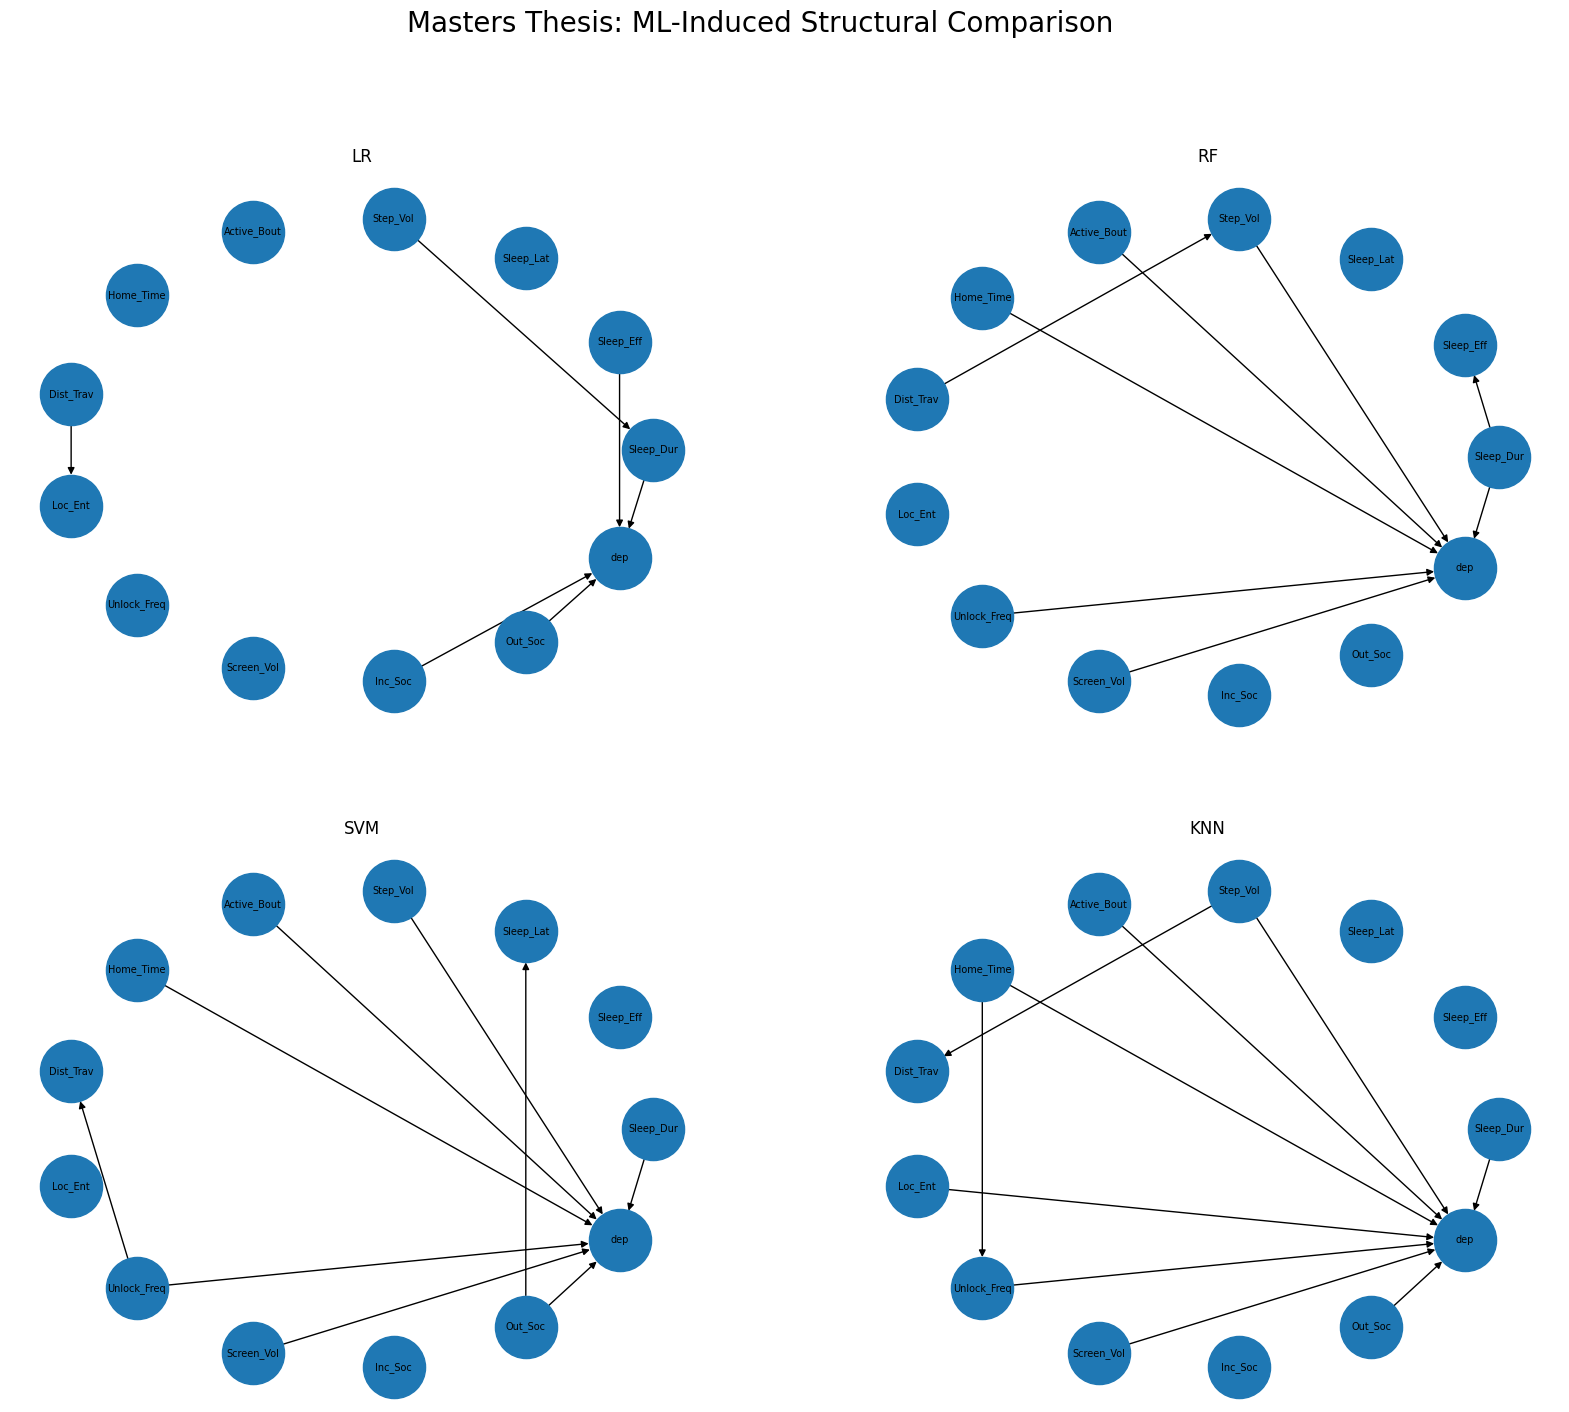

In [7]:
plt.figure(figsize=(20, 16))
for i, (m, g) in enumerate(zip(['LR','RF','SVM','KNN'], [G_lr, G_rf, G_svm, G_knn])): 
    plt.subplot(2,2,i+1); nx.draw(g, nx.circular_layout(g), with_labels=True, node_size=2000, font_size=7); plt.title(m)
plt.suptitle("Masters Thesis: ML-Induced Structural Comparison", fontsize=20)